In [1]:
import sys
sys.path.insert(0, '../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings, balanced_subsample
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

# Load Dataset

In [5]:
path_to_db='../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]
    

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [6]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )

df = df[df.h_target == 1]
red_class = [classes[i] for i in df.target.unique()]
df.head()

,target,h_target,metadata,fold
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,1
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,1
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4
5,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4
6,30,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,2


In [7]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,111.831480,54.815637,46.530396,47.713482,63.097985,40.124086,41.283977,39.126589,47.458985,44.103655,...,0.002231,-0.186397,8.548450,18.617724,4.990710,17.572631,2.932278,1,19,4
1,84.256878,45.595653,58.295530,40.866884,45.134938,42.510526,39.975935,35.020607,43.299812,33.619786,...,0.258236,-0.033466,8.731446,27.077679,6.396933,17.748301,6.235493,1,19,4
2,80.760855,50.189665,60.488470,45.657319,50.449612,37.361851,38.274903,37.943290,40.972668,33.157679,...,-0.005670,-0.237720,8.569524,15.897844,6.637912,13.312597,4.520961,1,19,4
3,96.653713,64.606767,43.944312,43.241847,47.136254,49.828710,44.103221,32.363491,37.862344,40.250450,...,0.314561,-0.078892,7.394061,16.869421,5.333168,14.245536,2.655378,1,19,4
4,95.009044,47.391309,52.084750,31.367530,41.518049,48.650198,45.167534,37.675397,36.512091,38.452338,...,0.014457,0.051697,6.610542,16.245310,8.406345,11.734778,3.869954,1,19,4


In [8]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,58.190871,43.667121,45.746463,42.343447,30.084076,48.247964,42.374778,39.387926,37.159804,49.153997,...,-0.151783,0.248175,14.496725,14.949878,3.585011,29.220897,3.871622,1,36,1
1,57.661319,60.080983,44.186640,48.768903,42.526813,44.876951,34.971382,41.118424,38.246856,45.606720,...,-0.072586,-0.007093,9.667292,28.537172,4.993364,22.758403,4.793919,1,36,1
2,67.650573,73.408686,44.682788,55.750333,39.236220,40.627880,41.786830,46.499063,40.762930,43.984468,...,0.264036,-0.195292,9.728142,24.602081,5.701362,22.282521,4.545848,1,36,1
3,59.714913,55.872608,54.856162,51.512034,49.218383,55.968103,40.890560,44.236659,38.496857,45.733907,...,0.434551,0.186542,13.989773,22.096882,6.127154,19.936294,6.681744,1,36,1
4,65.404965,69.993503,56.847376,54.966564,42.476325,41.917453,43.411913,41.171589,35.436546,40.675832,...,-0.132112,-0.347691,9.866833,15.716688,5.070683,14.813657,3.730182,1,36,1


In [9]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['target']

# Training

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=90)),
    ('feat_red', LinearDiscriminantAnalysis(n_components=10, solver='eigen')),
    ('classify', KNN(n_neighbors=15, algorithm='ball_tree'))
])

params = {
          'classify__n_neighbors': range(5,25,1),
          'classify__algorithm': ('ball_tree', 'kd_tree', 'brute')
         }

grsrch = GridSearchCV(clf, params, cv=5, n_jobs=10)

grsrch.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function f_classif at 0x7fb92a55e268>)), ('feat_red', LinearDiscriminantAnalysis(n_components=10, priors=None, shrinkage=None,
              solver='eigen...',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'classify__algorithm': ('ball_tree', 'kd_tree', 'brute'), 'classify__n_neighbors': range(5, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
grsrch.best_estimator_ 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function f_classif at 0x7fb92a55e268>)), ('feat_red', LinearDiscriminantAnalysis(n_components=10, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), ('classify', KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=23, p=2,
           weights='uniform'))])

In [12]:
sorted(grsrch.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_classify__algorithm',
 'param_classify__n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.31538992408557626
Confusion matrix, without normalization
[[81 11  2 ...  0  0  0]
 [ 2 15  8 ...  1  0  0]
 [ 0  5 44 ...  0  1  2]
 ...
 [ 0 28  0 ... 32  0  0]
 [ 0  5 11 ...  2 61  8]
 [ 0  0  0 ...  1  0 26]]


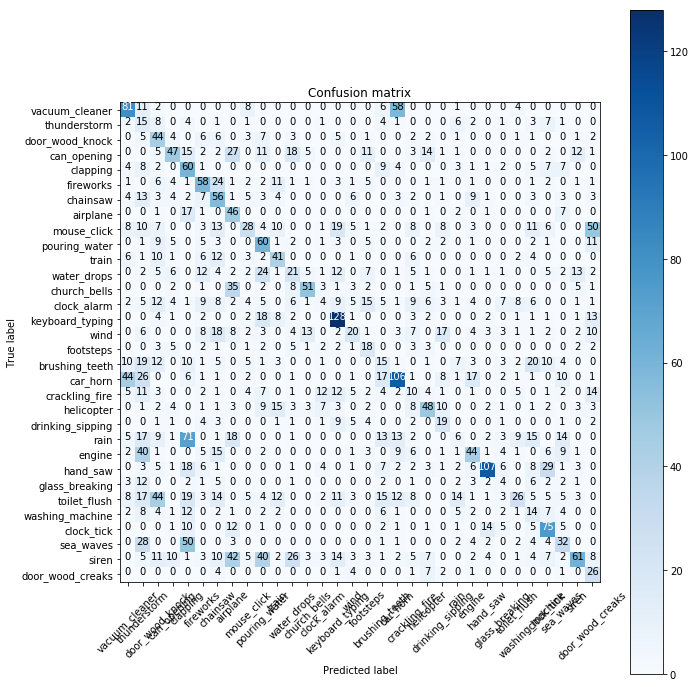

In [13]:
pred = grsrch.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, red_class)
plt.show()

In [14]:
pred_prob = grsrch.predict_proba(test_X)

# All Data

In [15]:
import seaborn as sns
misclassified = {
    'actual': [],
    'predicted': []
}
for cls in red_class:
    misclassified[cls] = []

for row, p, prob, Y in zip(test.iterrows(), pred, pred_prob, test_y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['actual'].append(classes[int(row[1]['target'])])
        misclassified['predicted'].append(classes[p])
        for i, cls in enumerate(red_class):
            misclassified[cls].append(prob[i])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,actual,airplane,brushing_teeth,can_opening,car_horn,chainsaw,church_bells,clapping,clock_alarm,clock_tick,...,rain,sea_waves,siren,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,vacuum_cleaner,0.0,0.130435,0.0,0.000000,0.0,0.0,0.000000,0.0,0.043478,...,0.086957,0.0,0.0,0.130435,0.043478,0.0,0.043478,0.130435,0.0,0.0
1,vacuum_cleaner,0.0,0.000000,0.0,0.086957,0.0,0.0,0.130435,0.0,0.086957,...,0.086957,0.0,0.0,0.260870,0.000000,0.0,0.043478,0.086957,0.0,0.0
2,vacuum_cleaner,0.0,0.130435,0.0,0.304348,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.043478,0.000000,0.0,0.478261,0.000000,0.0,0.0
3,vacuum_cleaner,0.0,0.304348,0.0,0.130435,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.217391,0.043478,0.0,0.043478,0.000000,0.0,0.0
4,vacuum_cleaner,0.0,0.391304,0.0,0.217391,0.0,0.0,0.043478,0.0,0.000000,...,0.043478,0.0,0.0,0.000000,0.130435,0.0,0.086957,0.000000,0.0,0.0


In [16]:
average_prob = misclassified.groupby('actual').mean()
average_prob.head()

,airplane,brushing_teeth,can_opening,car_horn,chainsaw,church_bells,clapping,clock_alarm,clock_tick,crackling_fire,...,rain,sea_waves,siren,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
actual,,,,,,,,,,,,,,,,,,,,,
airplane,0.051227,0.018080,0.011192,0.030564,0.019802,0.000000,0.230306,0.014206,0.047353,0.003444,...,0.056823,0.176065,0.002152,0.107619,0.024968,0.000430,0.006888,0.058115,0.005166,0.006027
brushing_teeth,0.001610,0.032206,0.013688,0.010467,0.136876,0.000000,0.001610,0.011272,0.011272,0.068438,...,0.013688,0.004831,0.004026,0.036232,0.033816,0.099839,0.109501,0.040258,0.013688,0.013688
can_opening,0.012422,0.001242,0.088199,0.002484,0.026087,0.023602,0.000000,0.099379,0.007453,0.045963,...,0.002484,0.002484,0.038509,0.008696,0.000000,0.002484,0.001242,0.009938,0.078261,0.022360
car_horn,0.010628,0.050242,0.003865,0.043478,0.063768,0.003865,0.043478,0.014493,0.047343,0.014493,...,0.050242,0.070531,0.025121,0.110145,0.022222,0.002899,0.023188,0.109179,0.021256,0.015459
chainsaw,0.001610,0.015700,0.003623,0.085749,0.075684,0.000403,0.004831,0.013688,0.042271,0.026570,...,0.025765,0.096216,0.013688,0.190016,0.012480,0.010467,0.028986,0.032609,0.007246,0.030193


In [17]:
average_prob = misclassified.groupby('predicted').mean()
average_prob

,airplane,brushing_teeth,can_opening,car_horn,chainsaw,church_bells,clapping,clock_alarm,clock_tick,crackling_fire,...,rain,sea_waves,siren,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
predicted,,,,,,,,,,,,,,,,,,,,,
airplane,0.038587,0.011957,0.011413,0.051087,0.026087,0.000000,0.086957,0.006522,0.042391,0.008696,...,0.048370,0.349457,0.007065,0.072283,0.011957,0.005978,0.001630,0.061957,0.008696,0.015761
brushing_teeth,0.000621,0.013043,0.013665,0.000621,0.034161,0.000000,0.001863,0.016149,0.013043,0.011180,...,0.001242,0.001242,0.005590,0.004969,0.006211,0.421118,0.024845,0.023602,0.016770,0.004348
can_opening,0.007013,0.005610,0.085554,0.004208,0.018934,0.010519,0.000000,0.054698,0.007013,0.035764,...,0.000000,0.000000,0.046283,0.006311,0.002805,0.002104,0.000000,0.002104,0.043478,0.026648
car_horn,0.012846,0.029644,0.009881,0.019763,0.019763,0.003953,0.063241,0.014822,0.099802,0.020751,...,0.035573,0.042490,0.014822,0.061265,0.022727,0.000988,0.010870,0.071146,0.005929,0.021739
chainsaw,0.000659,0.027009,0.002635,0.077734,0.057312,0.000000,0.007905,0.006588,0.044137,0.014493,...,0.014493,0.059947,0.002635,0.121871,0.010540,0.014493,0.018445,0.032938,0.005929,0.040184
church_bells,0.016817,0.021739,0.008203,0.015176,0.019688,0.000000,0.033634,0.018458,0.353158,0.014766,...,0.025431,0.050451,0.009844,0.032814,0.004512,0.012715,0.007383,0.097621,0.009024,0.015587
clapping,0.000805,0.070048,0.012882,0.021739,0.046699,0.000000,0.010467,0.022544,0.004026,0.033816,...,0.022544,0.008857,0.014493,0.039452,0.040258,0.044283,0.077295,0.039452,0.017713,0.008857
clock_alarm,0.013299,0.007673,0.031714,0.007161,0.032737,0.016368,0.001535,0.058312,0.010742,0.316113,...,0.006138,0.004092,0.038363,0.015857,0.025064,0.027621,0.022506,0.006138,0.022506,0.030691
clock_tick,0.010870,0.010870,0.082609,0.000000,0.002174,0.014493,0.008696,0.064493,0.019565,0.015217,...,0.000725,0.005797,0.040580,0.000000,0.001449,0.004348,0.003623,0.018841,0.046377,0.015942


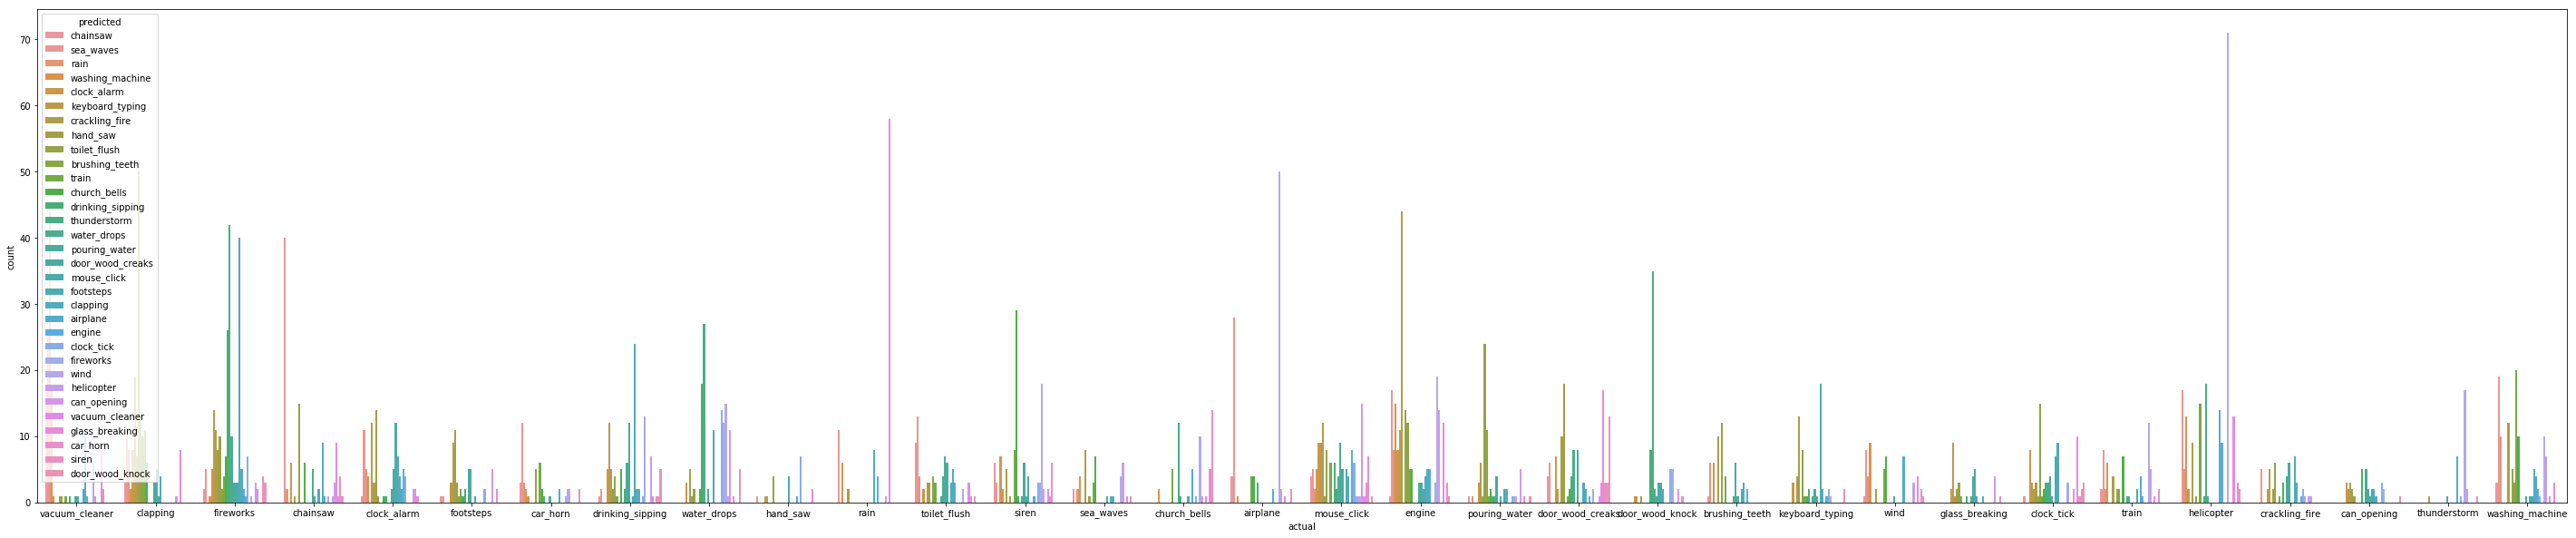

In [18]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='actual', hue='predicted',data=misclassified)